In [1]:
#import libraries and read the data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("UsArrests.csv")
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [2]:
print('Number of cases: {} Number of features: {}'.format(df.shape[0],df.shape[1]))

Number of cases: 50 Number of features: 5


In [3]:
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#The describe function give us insight into the statistical properties of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


Here we have picked out the key details about our variables. On first glance, we can see that assaults has the highest ratios by some distance and murders have the lowest.

In [4]:
# Count missing values
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
City,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


From the above information, I can see there are no missing values or values of as suspect type. Therefore, I will not need to worry about removing or substituting any values.

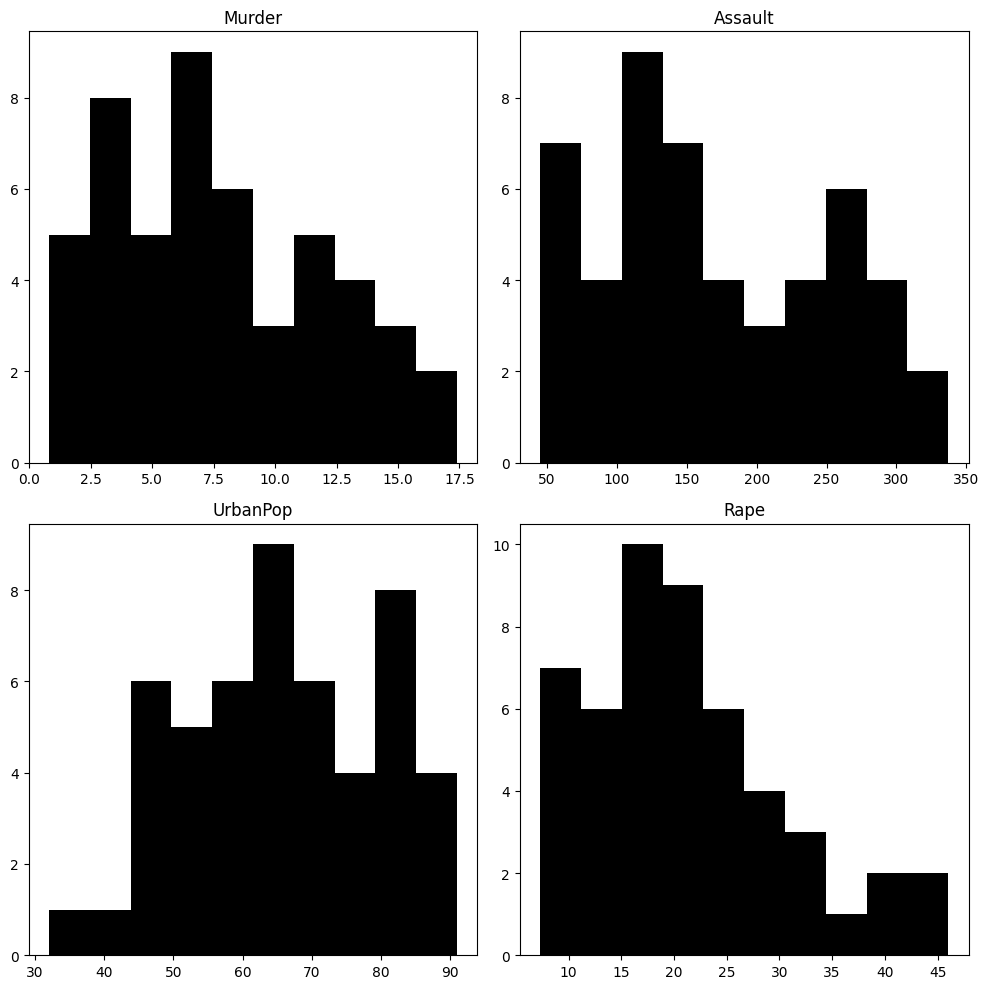

In [6]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(10, 10)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()
plt.show()

Here we can see our data for each variable as a histogram.

In [7]:
#set the data for correlation analysis
cities = df['City']
corr_df = df.drop(["City"],axis=1).corr()
labels =corr_df.columns

correlations = corr_df.corr()

<AxesSubplot: >

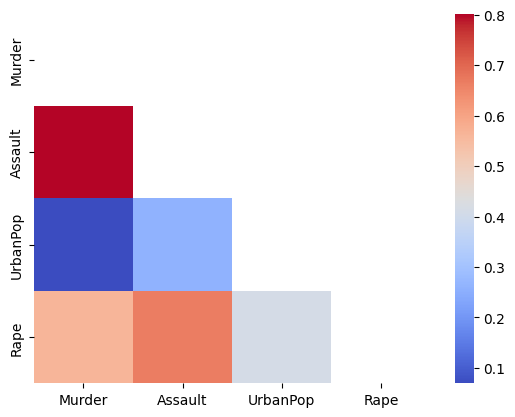

In [8]:
#create a heatmap to show the correlation of our variables
import seaborn as sns
mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm")

From the plot above, we can see that murders and assaults have a high correlation, meaning that more murders tend to happen in areas where assaults are more frequent. We can also see a similar relationship between assaults and rapes. Both of these relationships are understandable as these types of violent crime would likely go hand-in-hand. A clearly negative correlation is between the percentage of people living in urban areas and the number of murders and assaults. This means that the congregation of people in urban areas doesn't have a major impact on the levels of crime per 100,000 people. 

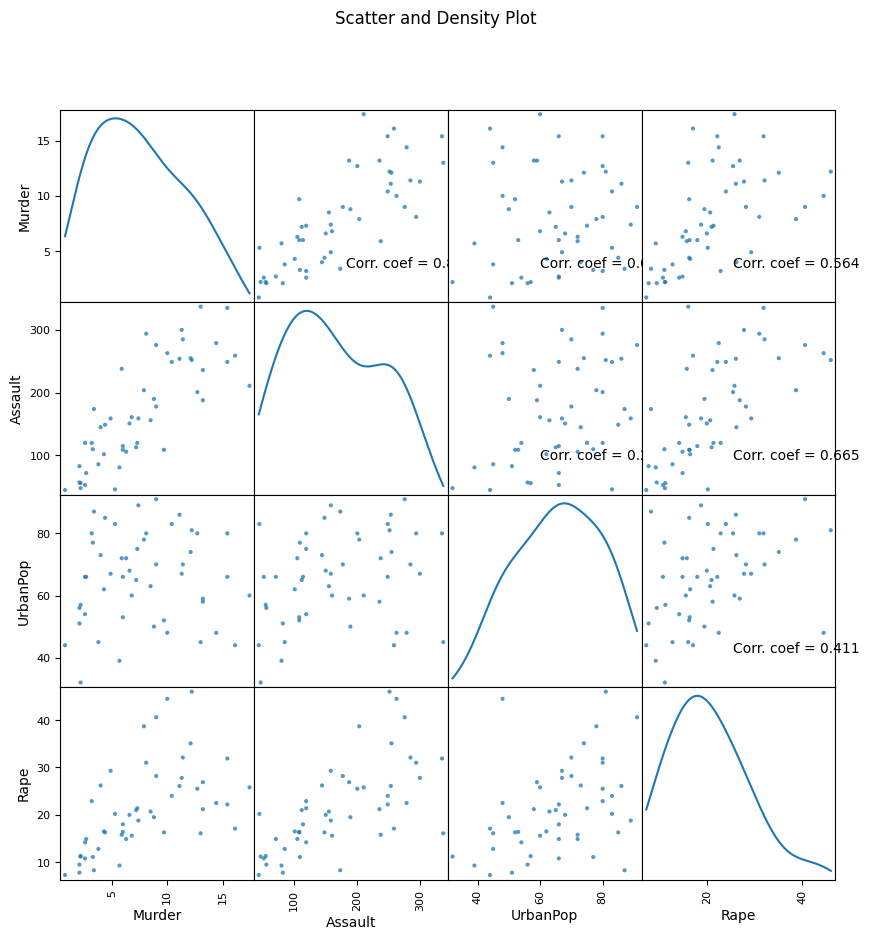

In [9]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()
    
plotScatterMatrix(df,10,10)

From the scatter graphs above, we can see the distribution of data for each variable, with the corresponding coefficient numbers. We can see that the violent crimes have a fairly linear trajectory in correlation to each other, which supports the theories from our heatmap above.

In [10]:
#create a PCA analysis model and fit to dataframe
from sklearn.decomposition import PCA

np.set_printoptions(precision=2)

X = df.drop(["City"],axis=1).values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.80,11.45,-2.49,2.41
1,92.83,17.98,20.13,-4.09
2,124.07,-8.83,-1.69,-4.35
3,18.34,16.70,0.21,-0.52
4,107.42,-22.52,6.75,-2.81


Below, we can see the standard deviation of the 4 components, along with the amount of variance that the principal component comprises in comparison to the total variance.

In [11]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [83.73 14.21  6.49  2.48]


In [12]:
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]


In [13]:
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Cumulative Proportion: [7011.11 7213.11 7255.22 7261.38]


In [14]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = cities[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

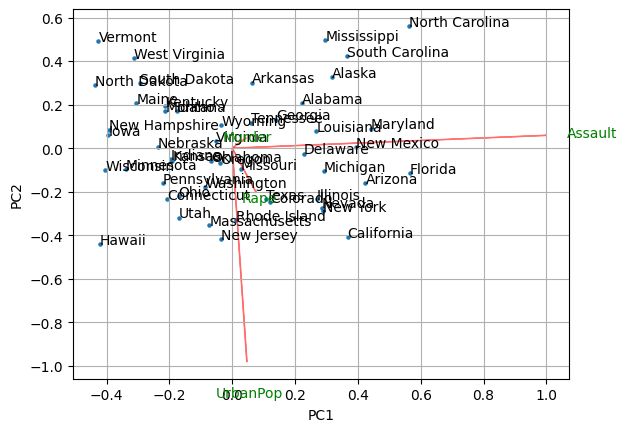

In [15]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(cities))
plt.show()

Our biplot above shows that the majority of states are overlapping and the first principle components are dominated by assaults, as identified earlier.

In [16]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


In [17]:
#standardise the data
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


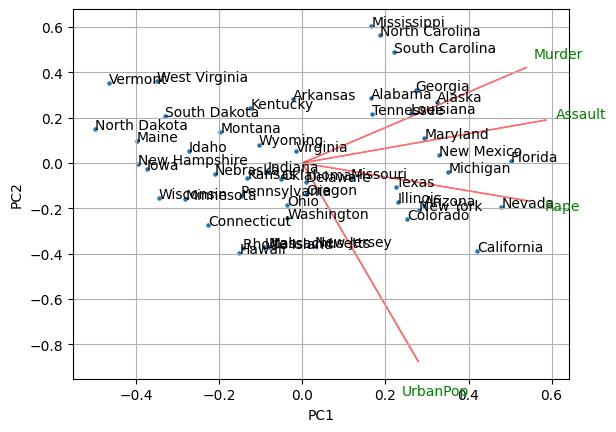

In [18]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

After standardising the data, we can see a far better spread of the states and the variables weighting. Both principal components are generally include a number of the cities that have higher murder and assault rates on the right hand side. The cities on the left have lower levels of crime. 

In [19]:
# Feature importance

pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


Text(0.5, 1.0, 'Cumulative Explained Variance')

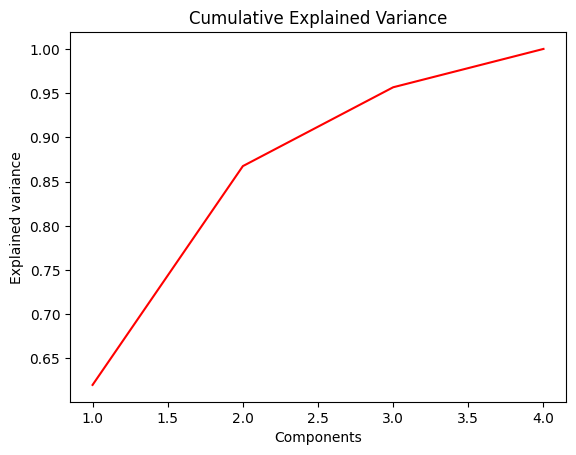

In [20]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

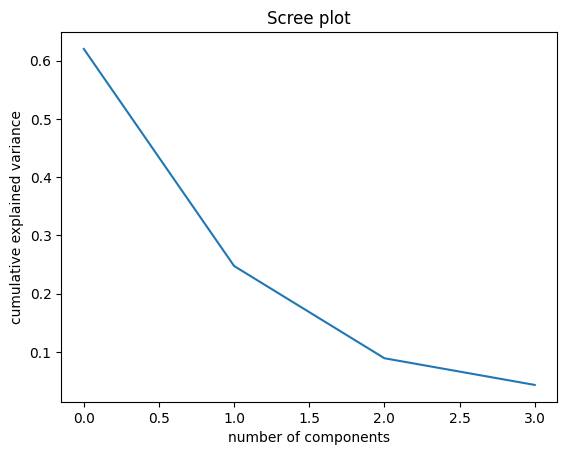

In [21]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

From the plots above, we can see that the first 3 components make around 95% of the variance, so we can reduce our number of components as such.

In [22]:
pca_df = pd.DataFrame(X_std_trans[:,0:3], index = df.index)
pca_df.head()

,0,1,2
0,0.986,1.133,-0.444
1,1.950,1.073,2.040
2,1.763,-0.746,0.055
3,-0.141,1.120,0.115
4,2.524,-1.543,0.599


In [23]:
#scale data for cluster analysis
scaler= StandardScaler()

data = df.iloc[:,1:].values
scaled_data = scaler.fit_transform(data)

Text(0, 0.5, 'Euclidean Distances')

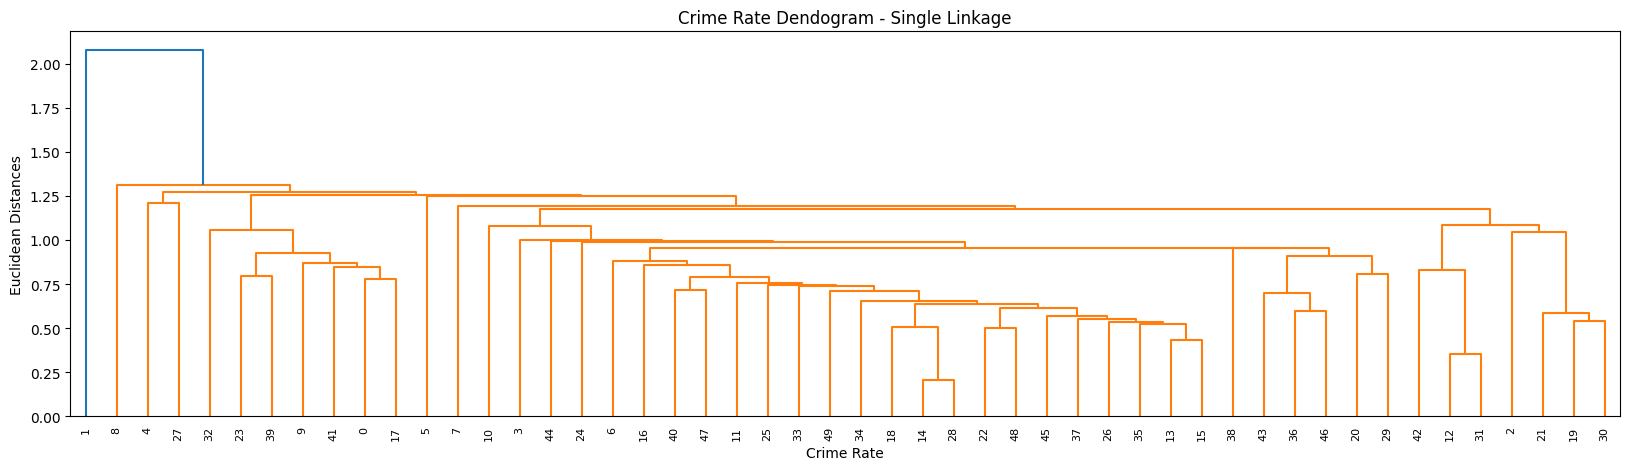

In [24]:
#import agglomerative clustering and create dendograms showing single, complete and average linkage for comparison
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

plt.figure(figsize=(20,5))
plt.title("Crime Rate Dendogram - Single Linkage")
dend = sch.dendrogram(sch.linkage(scaled_data, method='single'))
plt.xlabel('Crime Rate')
plt.ylabel('Euclidean Distances')

Text(0, 0.5, 'Euclidean Distances')

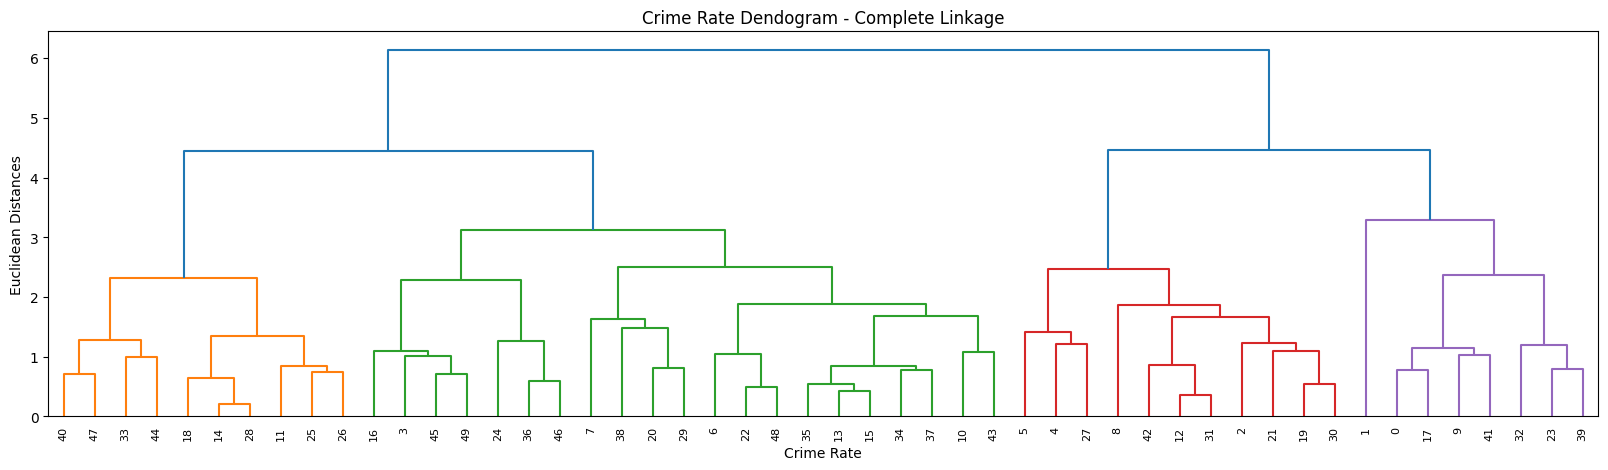

In [25]:
plt.figure(figsize=(20,5))
plt.title("Crime Rate Dendogram - Complete Linkage")
dend = sch.dendrogram(sch.linkage(scaled_data, method='complete'))
plt.xlabel('Crime Rate')
plt.ylabel('Euclidean Distances')

Text(0, 0.5, 'Euclidean Distances')

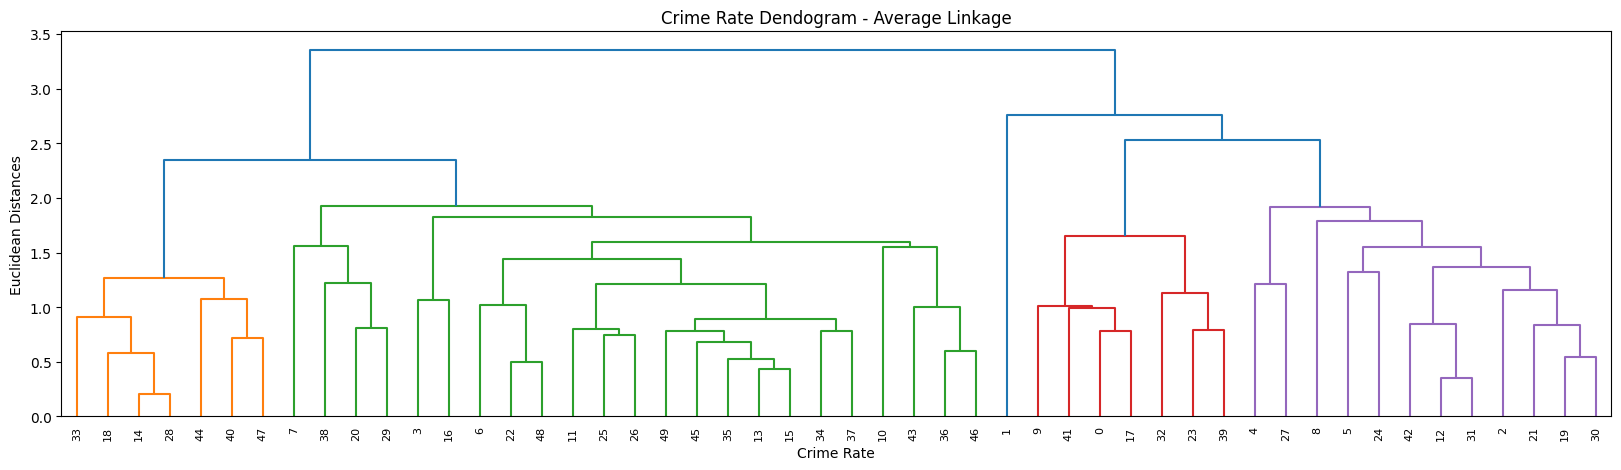

In [26]:
plt.figure(figsize=(20,5))
plt.title("Crime Rate Dendogram - Average Linkage")
dend = sch.dendrogram(sch.linkage(scaled_data, method='average'))
plt.xlabel('Crime Rate')
plt.ylabel('Euclidean Distances')

We can see from the dendograms above that the complete model provides the most complete and best shaped clusters.

In [27]:
# Fit the Agglomerative Clustering
 
model = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage ='complete')

# Fit and predict to have the cluster labels.
y_pred = model.fit_predict(data)
y_pred

array([0, 0, 0, 2, 0, 2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 2, 0,
       1, 0, 2, 1, 1, 0, 1, 2, 0, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 2, 2, 1,
       1, 2, 2, 1, 1, 2], dtype=int64)

In [28]:
# Fetch the cluster labels
df['cluster labels']= y_pred

Based on our predictions, we can now plot these against the different variables to show the average predictions using boxplots.

<AxesSubplot: xlabel='cluster labels', ylabel='Murder'>

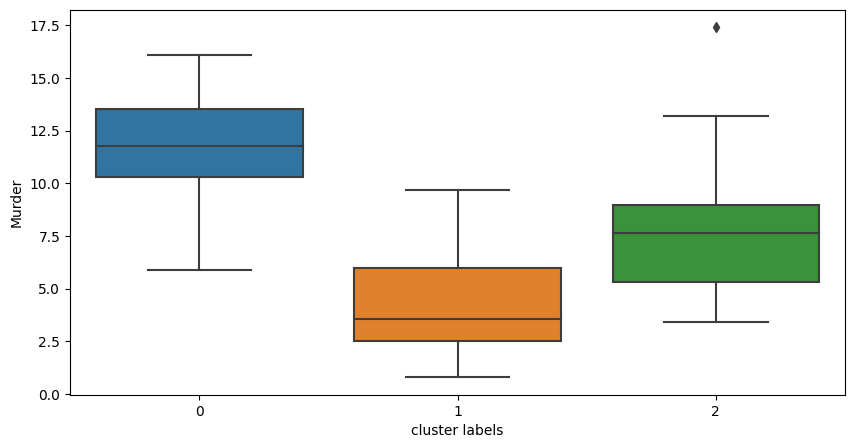

In [29]:
plt.figure(figsize=(10,5))
sns.boxplot(x='cluster labels', y='Murder', data=df)

<AxesSubplot: xlabel='cluster labels', ylabel='Rape'>

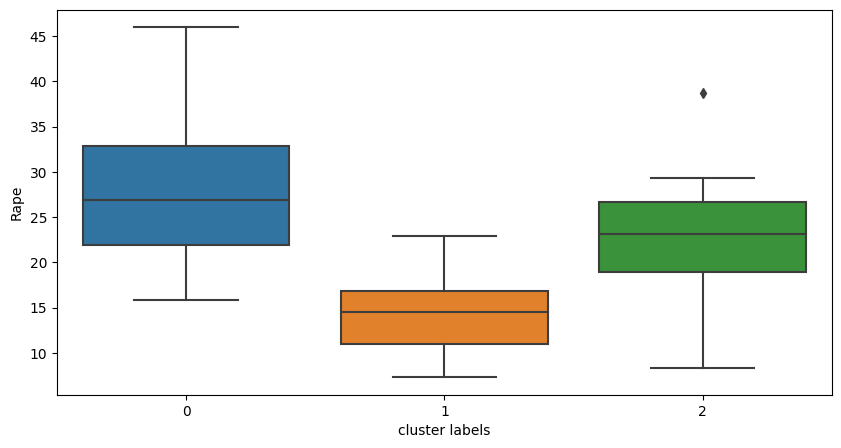

In [30]:
plt.figure(figsize=(10,5))
sns.boxplot(x='cluster labels', y='Rape', data=df)

<AxesSubplot: xlabel='cluster labels', ylabel='Assault'>

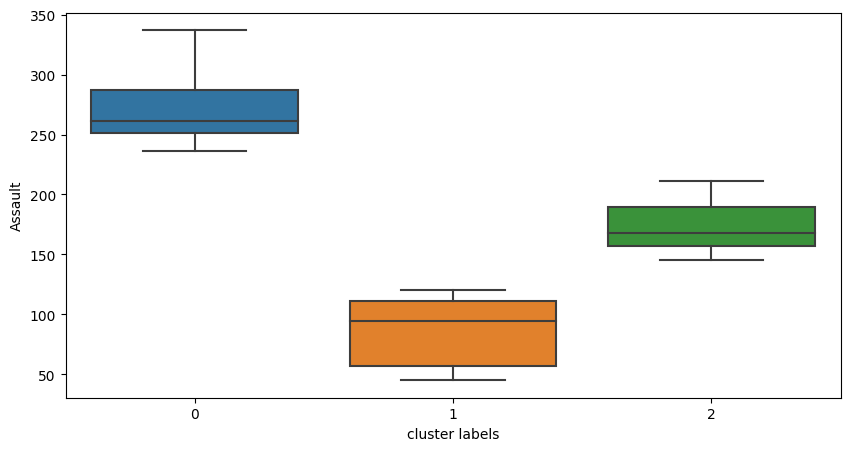

In [31]:
plt.figure(figsize=(10,5))
sns.boxplot(x='cluster labels', y='Assault', data=df)

We can also map our predictions against our cities and group them by the lowest levels of crime. The cities in cluster 0 seem to have higher levels of crime. Cluster 2 seems to have medium levels of crime and cluster 1 has lower levels of crime.

In [32]:
low_risk= df.groupby('cluster labels')['City'].unique()[1]
low_risk

array(['Connecticut', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Maine', 'Minnesota', 'Montana', 'Nebraska',
       'New Hampshire', 'North Dakota', 'Ohio', 'Pennsylvania',
       'South Dakota', 'Utah', 'Vermont', 'West Virginia', 'Wisconsin'],
      dtype=object)

In [33]:
medium_risk= df.groupby('cluster labels')['City'].unique()[2]
medium_risk

array(['Arkansas', 'Colorado', 'Georgia', 'Massachusetts', 'Missouri',
       'New Jersey', 'Oklahoma', 'Oregon', 'Rhode Island', 'Tennessee',
       'Texas', 'Virginia', 'Washington', 'Wyoming'], dtype=object)

In [34]:
high_risk= df.groupby('cluster labels')['City'].unique()[0]
high_risk

array(['Alabama', 'Alaska', 'Arizona', 'California', 'Delaware',
       'Florida', 'Illinois', 'Louisiana', 'Maryland', 'Michigan',
       'Mississippi', 'Nevada', 'New Mexico', 'New York',
       'North Carolina', 'South Carolina'], dtype=object)

We can plot our groups on a scatter graph to show the distribution of the cities in the lower, medium and higher risk areas.

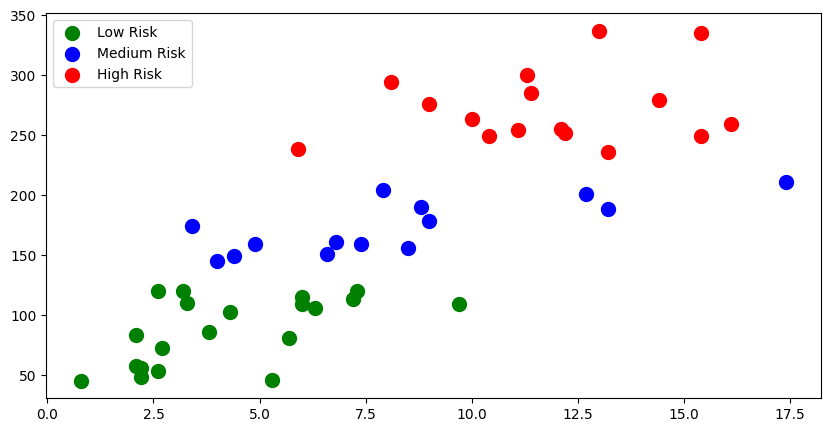

In [35]:
plt.figure(figsize=(10,5))
plt.scatter(data[y_pred==1, 0], data[y_pred==1, 1], s=100, c='green', label ='Low Risk')
plt.scatter(data[y_pred==2, 0], data[y_pred==2, 1], s=100, c='blue', label ='Medium Risk')
plt.scatter(data[y_pred==0, 0], data[y_pred==0, 1], s=100, c='red', label ='High Risk')
plt.legend()
plt.show()

Fianlly, we can use a K-means cluster algorithm to provide a local optimum.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


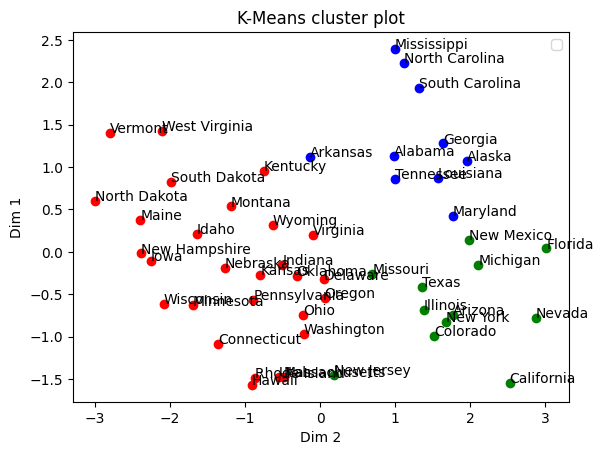

In [36]:
from sklearn.cluster import KMeans

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=3
kmeans = KMeans(n_clusters=k, init='k-means++', n_init= 'auto', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()